In [120]:
import tensorflow as tf
from prepare_dataset import create_dataset_from_tfrecord

## Build CNN Model

In [129]:
def build_conv_layers(x, cnt_layers, prefix):
    # conv layers
    for i in range(cnt_layers):
        # conv layer i
        x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name=f'{prefix}_conv_{i+1}')(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same', name=f'{prefix}_max_pool_{i+1}')(x)

    # relu activation
    x = tf.keras.layers.Activation('relu')(x)

    return tf.keras.layers.Flatten()(x) 


def CNN_crop_inputs(image_shape, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')
    
    # split into three sets: 
    # - half image in left side: the first label
    # - entire image: the second, third labels
    # - hale image in right side: the last label
    H, W, C = image_shape
    x1 = tf.keras.layers.Cropping2D(cropping=((0, 0), (0, int(W/2))), name='left_half')(image_input)
    x2 = tf.keras.layers.Cropping2D(cropping=((0, 0), (int(W/2), 0)), name='right_half')(image_input)
    
    # build layers
    x1 = build_conv_layers(x1, 5, 'A0')
    x = build_conv_layers(image_input, 6, 'A1_2')
    x2 = build_conv_layers(x2, 5, 'A3')

    # combine multi-outputs
    labels = [
        tf.keras.layers.Dense(n_class, name=f'{output_label}_0')(x1),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_1')(x),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_2')(x),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_3')(x2)
    ] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model


In [130]:
image_shape = (60, 120, 1)
n_class = 26

model = CNN_crop_inputs(image_shape, n_class, name='cnn_crop_inputs', output_label='A')
model.summary()

Model: "cnn_crop_inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
A1_2_conv_1 (Conv2D)            (None, 60, 120, 32)  320         input_image[0][0]                
__________________________________________________________________________________________________
left_half (Cropping2D)          (None, 60, 60, 1)    0           input_image[0][0]                
__________________________________________________________________________________________________
A1_2_max_pool_1 (MaxPooling2D)  (None, 30, 60, 32)   0           A1_2_conv_1[0][0]                
____________________________________________________________________________________

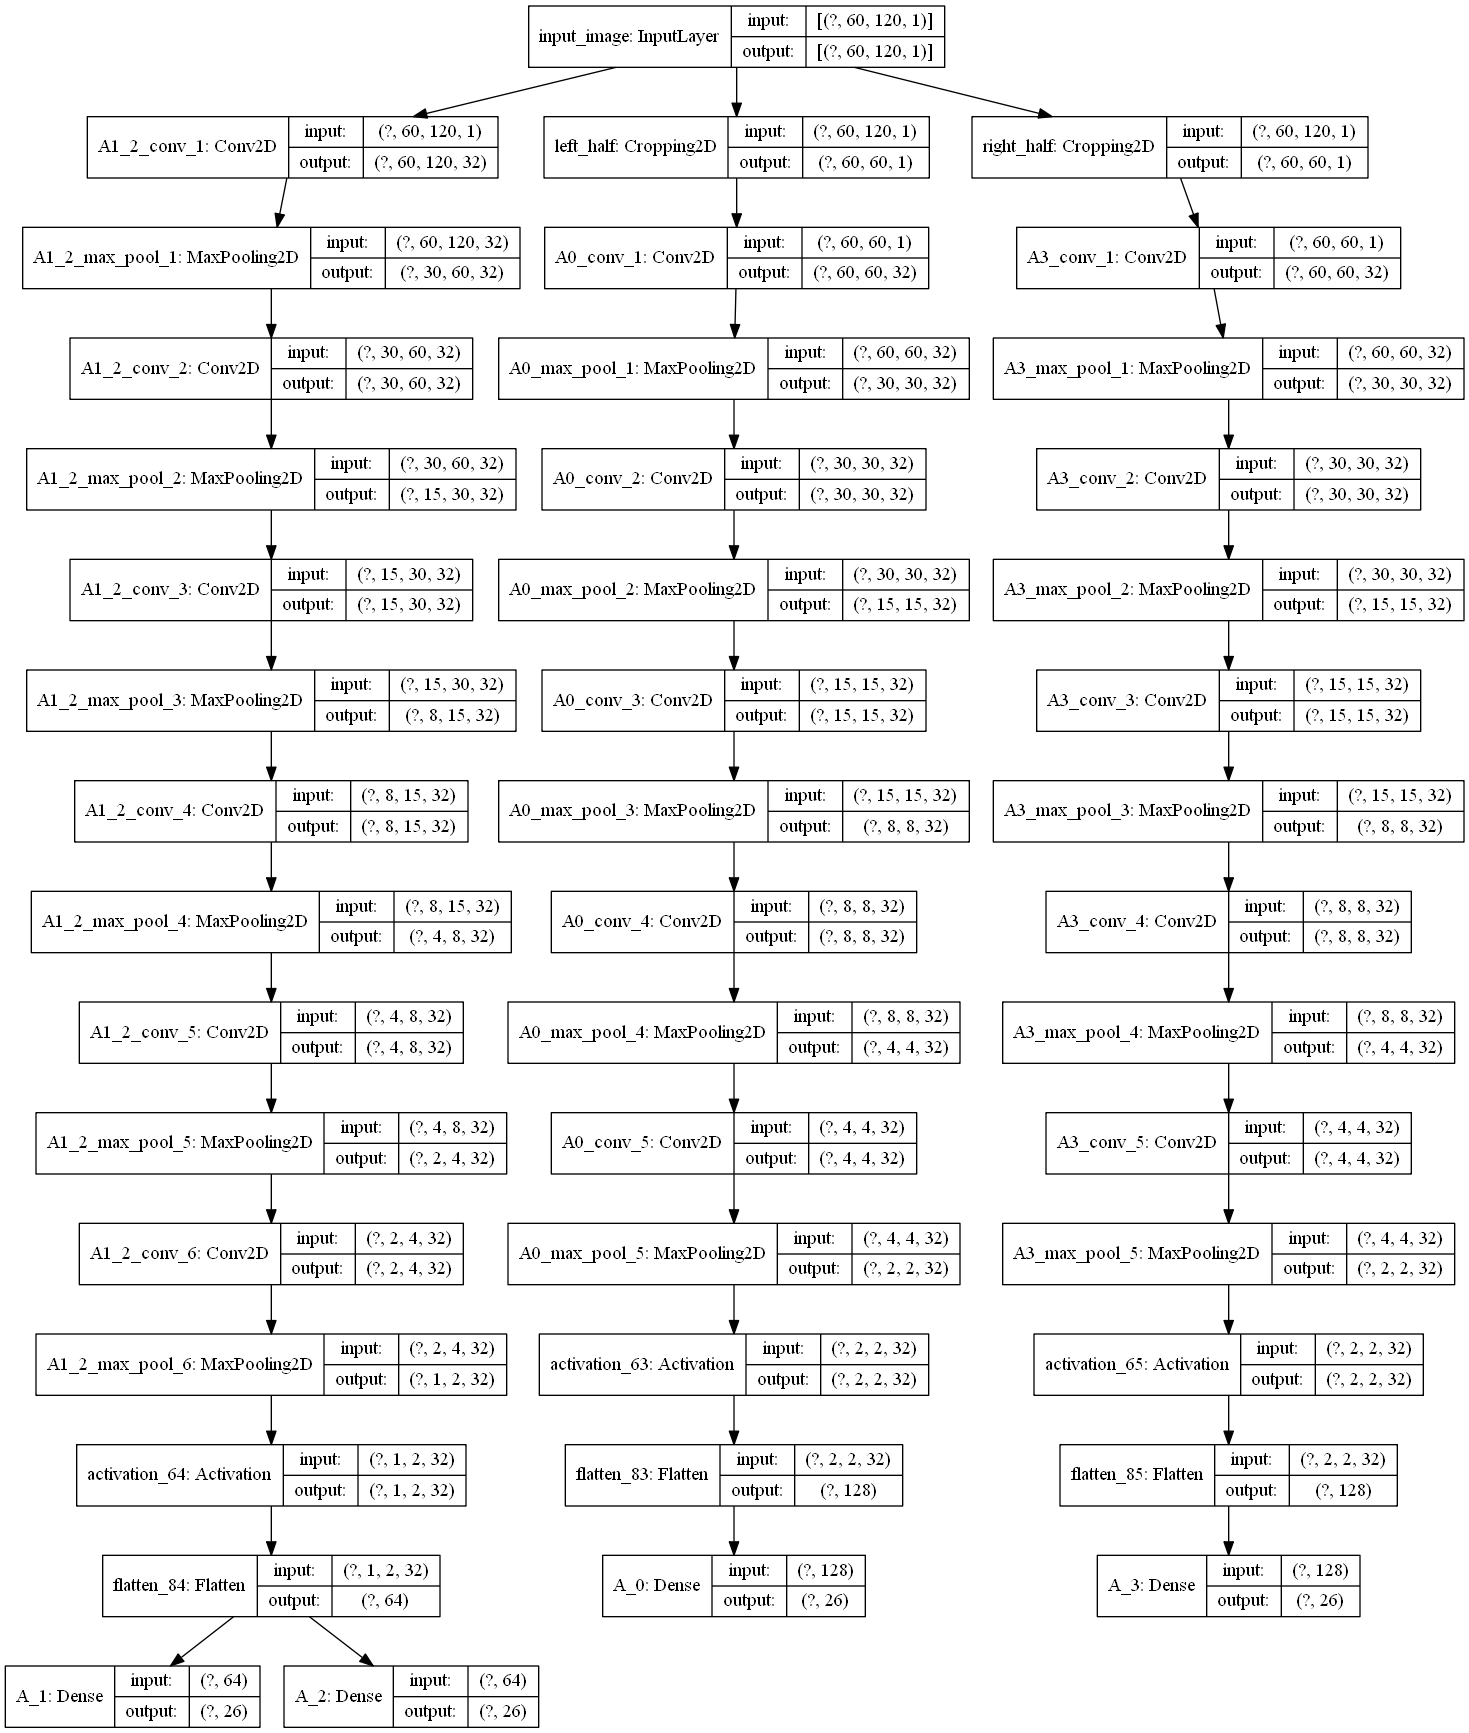

In [131]:
tf.keras.utils.plot_model(model, f'{model.name}.png', show_shapes=True)

## Train Model

In [104]:
# load dataset
train_ds = create_dataset_from_tfrecord('dataset/qq_captcha_train.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A')
test_ds = create_dataset_from_tfrecord('dataset/qq_captcha_test.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A')

In [105]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.005, 0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
import os

# load model if exists
model_dir = os.path.join('models', model.name)
if os.path.exists(model_dir):
    model = tf.keras.models.load_model(model_dir)

model.fit(train_ds, 
          epochs=2, 
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard'))])

Epoch 1/2
316/316 [==============================] - 390s 1s/step - loss: 13.1841 - A_0_loss: 2.8058 - A_1_loss: 3.4452 - A_2_loss: 3.5110 - A_3_loss: 3.4221 - A_0_accuracy: 0.1302 - A_1_accuracy: 0.0555 - A_2_accuracy: 0.0534 - A_3_accuracy: 0.0551
Epoch 2/2
316/316 [==============================] - 289s 916ms/step - loss: 11.4270 - A_0_loss: 1.7624 - A_1_loss: 3.2429 - A_2_loss: 3.2601 - A_3_loss: 3.1616 - A_0_accuracy: 0.3796 - A_1_accuracy: 0.0602 - A_2_accuracy: 0.0571 - A_3_accuracy: 0.0582
